In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns; sns.set()
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from pandas.util import hash_pandas_object

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
#Uncomment next line when u first use nltk and press download when all in selected on the windows of nltk downloads
#nltk.download()

import string
from ast import literal_eval
from tqdm import tqdm
#To detect language for stemming
# https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
from langdetect import detect

## Import data

In [2]:
raw_data = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep = '\t')

/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Drop columns not needed, explore missing values, and delete rows with zero or one value present

In [3]:
columns2keep = ['energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g','fiber_100g','proteins_100g','nutrition-score-uk_100g',
    'nutrition_grade_fr','main_category_en','packaging','categories','labels_en',
    'pnns_groups_1','pnns_groups_2','product_name','ingredients_text','nutrition_grade_fr']

In [4]:
data = raw_data[columns2keep]

In [5]:
data = data.replace("unknown",np.nan)

In [6]:
data = data.loc[(~data.isnull()).sum(axis=1)>1]

# FOOD CATEGORIES

In our first step, we aim to categorize products according to their Food Category. The PNNS ("Programme national nutrition santé" in French) aims at categorizing food in several major classes: Dairies, Composite, Fish Meat Eggs, Beverages, Fat Sauces, Fruits Vegetables, Starchy, and Snacks.

https://www.cerin.org/rapports/groupes-groupes-daliments/

### From pnns_groups_1 column

We map the given pnns categories to our 8 major ones

In [7]:
data["pnns_groups_1"].value_counts()

Sugary snacks              57997
Milk and dairy products    43467
Fish Meat Eggs             42475
Cereals and potatoes       34187
Beverages                  29118
Fat and sauces             28114
Composite foods            25430
Fruits and vegetables      24419
Salty snacks               19825
sugary-snacks               3469
fruits-and-vegetables       2898
cereals-and-potatoes          43
salty-snacks                   5
Name: pnns_groups_1, dtype: int64

In [8]:
# dictionnary to normalize category names into PNNS category
pnns1_category = {
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}
data.loc[:,'food_category'] = data['pnns_groups_1'].map(pnns1_category)

In [9]:
# New pnns categories
data["food_category"].value_counts()

Snacks               81296
Dairies              43467
Fish Meat Eggs       42475
Starchy              34230
Beverages            29118
Fat Sauces           28114
Fruits Vegetables    27317
Composite            25430
Name: food_category, dtype: int64

### From pnns_groups_2 column

We notice that several products haven't been categorized but have a non missing value in pnns_groups_2

In [10]:
# Values of pnns_groups_2 which haven't been classified in food_category
data.loc[data.food_category.isnull()]["pnns_groups_2"].value_counts()

Alcoholic beverages       10378
Pizza pies and quiches      399
Name: pnns_groups_2, dtype: int64

In [11]:
# dictionnary to extend food_categories from pnns_groups_2
pnns2_category = {
 'Pizza pies and quiches' : 'Composite', 
 'Alcoholic beverages' : 'Beverages',
}
data.loc[data.food_category.isnull(),'food_category'] = data.loc[data.food_category.isnull()]['pnns_groups_2'].map(pnns2_category)

In [12]:
data["food_category"].value_counts()

Snacks               81296
Dairies              43467
Fish Meat Eggs       42475
Beverages            39496
Starchy              34230
Fat Sauces           28114
Fruits Vegetables    27317
Composite            25829
Name: food_category, dtype: int64

### From main_category_en column

We complete our categorization with the help of the 'main_category_en' column

In [13]:
data.loc[data.food_category.isnull()]["main_category_en"].value_counts().head(30)

Beverages                          9408
Groceries                          5884
Plant-based foods and beverages    5218
Snacks                             3482
Dietary supplements                1995
Dairies                            1567
Desserts                           1277
Sweeteners                         1237
Baby foods                         1231
Cooking helpers                     740
Crêpes and galettes                 686
Food additives                      581
Non food products                   518
Canned foods                        480
Frozen foods                        452
Spreads                             395
Cocoa and chocolate powders         322
Licensed products                   306
Syrups                              286
Chips and fries                     265
es:bolleria-industrial              237
fr:bloc-de-foie-gras-de-canard      229
Pizza dough                         204
Banana-crisps                       197
Breakfasts                          197


In [14]:
# After inspecting the food type for the 30 most frequent values in main_category_en, we create the following dictionary
maincategoryen_category = {
'Beverages' : 'Beverages',
'Snacks' : 'Snacks',
'Dairies' : 'Dairies',
'Desserts' : 'Dairies',
'Crêpes and galettes' : 'Snacks',
'Cocoa and chocolate powders': 'Snacks',
'Syrups':'Fat Sauces',
'Chips and fries': 'Snacks',
'es:bolleria-industrial': 'Snacks',
'fr:bloc-de-foie-gras-de-canard': 'Fish Meat Eggs' ,
'Pizza dough' : 'Starchy',
'Breakfast' : 'Starchy',
'Banana-crisps' : "Snacks",
'Fish eggs' : 'Fish Meat Eggs',
'Terrines' : 'Fish Meat Eggs',
'fr:escalopes' : 'Fish Meat Eggs',
'Salads' : 'Fruits Vegetables',
'fr:pilons-de-poulet' : 'Fish Meat Eggs'
}

data.loc[data.food_category.isnull(),'food_category'] =  data.loc[data.food_category.isnull(),'main_category_en'].map(maincategoryen_category)

In [15]:
sum(data["food_category"].value_counts())/len(data)

0.3746498453334856

**After these steps, we managed to categorize 37% of our date among PNNS groups.**

For the unclassified data, the other columns don't bring any strong evidence for the categorization of the product. For instance, a lot of Dietary Supplements or Non Food Products are unclassified. Also, the table beneath shows that no column with above 10% completeness for uncategorized data gives us direct information on food categories.

In [16]:
completeness = raw_data.iloc[data[data.food_category.isnull()].index].count().sort_values(ascending=False)/len(data.loc[data.food_category.isnull()])
completeness.loc[completeness>0.1]

code                                       1.000000
states_en                                  1.000000
pnns_groups_1                              1.000000
pnns_groups_2                              1.000000
states                                     1.000000
states_tags                                1.000000
last_modified_datetime                     1.000000
last_modified_t                            1.000000
created_datetime                           1.000000
created_t                                  1.000000
creator                                    1.000000
url                                        1.000000
countries                                  0.998816
countries_en                               0.998816
countries_tags                             0.998816
product_name                               0.994096
energy_100g                                0.940715
proteins_100g                              0.937935
carbohydrates_100g                         0.935725
fat_100g    

In [17]:
classified_data = data.loc[~data.food_category.isnull()]
unclassified_data = data.loc[data.food_category.isnull()]

In [18]:
classified_data.loc[~classified_data.ingredients_text.isnull(),"ingredients_text"].count()/len(classified_data)

0.630505126296229

40% of the remaining data has a list of ingredients, and 62% of our classified data also has a list of ingredients. We will use word similarities on the words in ingredient_text to associate unclassified products to categories if the similarity is big enough.

### Using Ingredients_text column 

In [19]:
# We clean the list of ingredients by removing punctuation and numbers

def clean_text(df,col):
    
    caracters2delete = ['%','-',':',',',"  ",'(',')',';','/','_','*','\d+','.','\'','[',']']

    df.loc[:,col] = df.loc[:,col].str.lower()
    for c in caracters2delete:
        df.loc[:,col] = df.loc[:,col].str.replace(c,' ')

    

clean_text(classified_data,"ingredients_text")
clean_text(unclassified_data,"ingredients_text")

/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
# We compute the set of words for each category by keeping the 100 most frequent words that aren't stopWords

from collections import Counter
import nltk
from nltk.corpus import stopwords

# The dominant language in the ingredients in french
stopWords = stopwords.words('french') + ["kg","g","v","a","b","k","e","mg","and","of","ml","cl"]

def jaccard_similarity(list1, list2):
    s1 = set(list1) # gives the keys
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def createWordSet(df):   
    count = Counter([ word for sentence in df.loc[~df["ingredients_text"].isnull(),"ingredients_text"].tolist() for word in sentence.split(" ")[:5] if word not in stopWords])
    count[""] = 0
    n = sum(count.values())
    return dict([(word[0],word[1]/n) for word in count.most_common(100)])

category_words = classified_data.groupby("food_category").apply(createWordSet)
category_words["Beverages"]

{'eau': 0.0808946783802888,
 'jus': 0.05653842270019186,
 'sucre': 0.035140866404119966,
 'water': 0.02599212359890942,
 'gazéifiée': 0.014924770271634857,
 'malt': 0.014046248611531859,
 'orange': 0.013995758860951227,
 'orge': 0.011945874987377562,
 'pomme': 0.01147127133191962,
 'thé': 0.01139048773099061,
 'contient': 0.010289811168332828,
 'agua': 0.010219125517519943,
 'base': 0.009885893163687771,
 'juice': 0.009057861254165404,
 'wasser': 0.008987175603352519,
 'sulfites': 0.008431788346965566,
 'fruits': 0.007997576491972129,
 'source': 0.007876401090578612,
 'fructose': 0.007462385135817429,
 'sugar': 0.007169544582449763,
 'tea': 0.0071190548318691305,
 'café': 0.00700797738059174,
 'sirop': 0.006614157326062809,
 'carbonated': 0.0064525901242047864,
 'vert': 0.005836615167121075,
 'minérale': 0.0058063213167726955,
 'acidifiant': 0.005705341815611431,
 'vin': 0.005574068464101787,
 'purée': 0.005574068464101787,
 'naturelle': 0.005422599212359891,
 'arôme': 0.00498838735736

In [21]:
category_words["Fish Meat Eggs"]

{'porc': 0.0869895314712882,
 'viande': 0.0667240951365873,
 'sel': 0.03347885123592881,
 'jambon': 0.028178884816983253,
 'poulet': 0.020177833583974538,
 'filets': 0.016892730431735555,
 'origine': 0.01649851805346688,
 'water': 0.015374282752478428,
 'saumon': 0.013286417193499876,
 'filet': 0.011870172723423516,
 'sardines': 0.01182637134806033,
 'thon': 0.011665766305061978,
 'eau': 0.010702136047071879,
 'gras': 0.010585332379436714,
 'beef': 0.010103517250441663,
 'salt': 0.009256690660086726,
 'huile': 0.008190857192915858,
 'dextrose': 0.008176256734461462,
 'dinde': 0.007869647106919158,
 'atlantique': 0.007782044356192785,
 'foie': 0.00747543472865048,
 'schweinefleisch': 0.007402432436378502,
 'pork': 0.007271028310288943,
 'frais': 0.0065702063044779605,
 'chicken': 0.006482603553751588,
 'bovine': 0.006424201719934006,
 'sugar': 0.006365799886116424,
 'poitrine': 0.006351199427662028,
 'speisesalz': 0.005971587507847746,
 'salmo': 0.005737980172577419,
 'œufs': 0.00569417

The example shown above is the word dictionary for 'Beverages'. For each category we obtain a dictionary of the 100 most frequent words with normalized counts.

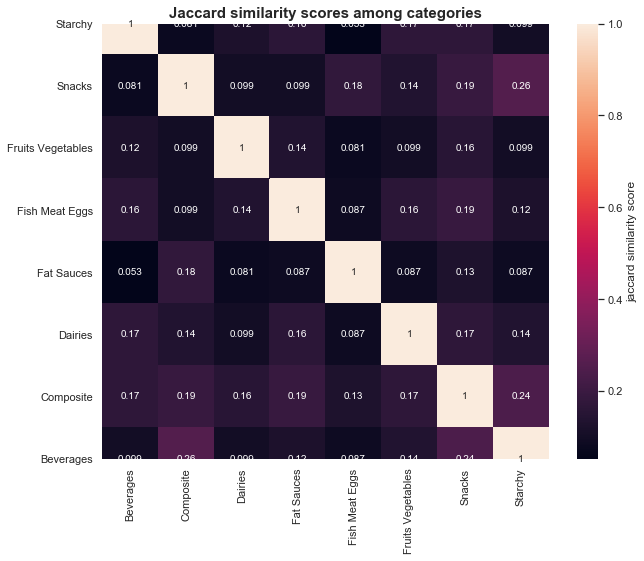

In [22]:
columns = category_words.index.values
n = len(columns)
similarity_matrix = np.zeros((n,n))

for idx1,name1 in enumerate(columns):
    for idx2,name2 in enumerate(columns):
        similarity_matrix[idx1,idx2] = jaccard_similarity(category_words[name1],category_words[name2])

plt.figure(figsize=(10,8))
sns.heatmap(similarity_matrix, annot=True, cbar_kws={'label': 'jaccard similarity score'})
plt.title("Jaccard similarity scores among categories", fontsize=15, fontweight="bold")
plt.xticks(np.arange(n)+0.5,columns,rotation='vertical')
plt.yticks(np.arange(n)+0.5,np.flip(columns,axis=0),rotation='horizontal')
plt.show()

We see that the dictionaries are rather distinct. The 'Composite' category shares words with other categories since it groups products from different food categories. We decide to drop 'Composite' for further categorization as it is too subjective to associate multiple categories to products with only the list of ingredients. We obtain more accurate results by associating only one category to products if the similarity is above an experimentally-set threshold.

In [23]:
category_words = category_words.drop("Composite")

In [24]:
# We split the unclassified data ingredient list in a list of non-stop words 

unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] = \
    unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] \
    .apply(lambda x: [word for word in x.split() if word not in stopWords])

To compute the similarity between a list of ingredients and a category, we compute a score. Each word in the list adds to the category score its importance in the category dictionary (normalized count in the dictionary) which is also weighted by its position in the ingredients list. The idea the ingredients of a product are listed in order of importance. We only consider the 10 first words in the ingredient list. We also divide the word score by the number of dictionaries it which it occurs. The ingredient is less representative of a food category if it also represents other categories.

We then categorize a product if its maximum similarity is above a 0.3 threshold. This threshold was set experimentally by manually looking up a product's information with its computed category.

In [25]:
intersections = dict();
for col in category_words.index.values:
    for word in set(category_words[col]):
        intersections[word] = intersections.get(word,0)+1


def similarity_dic(ingredients):
    dic = {}
    n = 10        
    for cat in category_words.index.values:
        score = 0
        for idx,word in enumerate(ingredients[:n]):
            score += category_words[cat].get(word,0)*(n-idx)/intersections.get(word,1)
        dic[cat] = score
    total = sum(dic.values())
    if (total != 0) :
        dic = {k: v / total for k, v in dic.items()}
    return dic

similarities = unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),"ingredients_text"] \
            .apply(similarity_dic).apply(pd.Series)
    
# We remove products that have no similarities
similarities = similarities[(similarities.T != 0).any()]

similarities["category"] = similarities.loc[similarities.max(axis=1)>0.3].idxmax(axis=1)

# List some results with product_names
pd.concat([similarities,data.loc[similarities.index,"product_name"]], axis=1).head(20)

,Beverages,Dairies,Fat Sauces,Fish Meat Eggs,Fruits Vegetables,Snacks,Starchy,category,product_name
15,0.311077,0.080862,0.169057,0.314245,0.106719,0.013350,0.004691,Fish Meat Eggs,Solène céréales poulet
22,0.061098,0.613735,0.029348,0.001829,0.032595,0.229587,0.031809,Dairies,Crème dessert chocolat
29,0.083143,0.015102,0.055783,0.022982,0.036839,0.344848,0.441302,Starchy,Baguette Poitevin
38,0.057633,0.009985,0.045428,0.009515,0.032507,0.389433,0.455500,Starchy,Suedois saumon
43,0.141121,0.041892,0.290221,0.098395,0.327222,0.080132,0.021017,Fruits Vegetables,Salade shaker taboulé
44,0.079030,0.005498,0.441663,0.025064,0.054759,0.347106,0.046880,Fat Sauces,Banana Chips Sweetened (Whole)
45,0.014440,0.018865,0.032242,0.019036,0.022353,0.229933,0.663131,Starchy,Peanuts
49,0.145655,0.504373,0.089042,0.020238,0.040626,0.180702,0.019364,Dairies,Fromage blanc à la creme de marron
54,0.000000,0.000000,0.004391,0.000000,0.000000,0.452273,0.543336,Starchy,Sandwich solene céréales sicilien
96,0.079064,0.113723,0.280924,0.001634,0.165472,0.173231,0.185952,NaN,Organic Salted Nut Mix


We see that the categorization yields good results. Some products stay uncategorized by lack of dominant similarity but those who are appear to be well categorized with small errors (ex: Banana Chips Sweetened in row 44)

In [26]:
# We assign the new categroy values to those with missing categories
data.loc[data.food_category.isnull(),"food_category"] = similarities["category"]

sum(data["food_category"].value_counts())/len(data)

0.5868279254042907

The new number of categorized products represents 57% of the data kept.

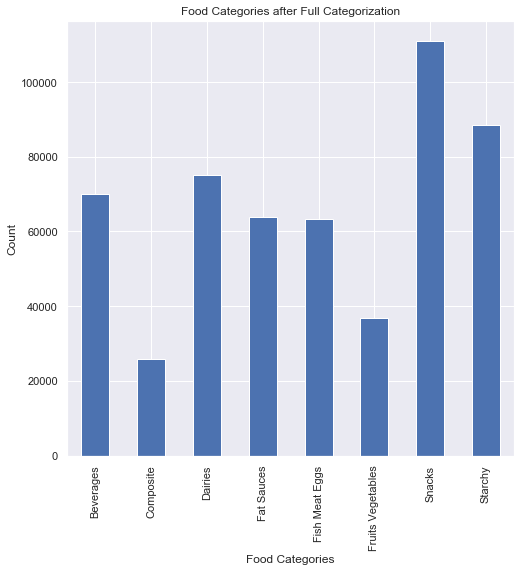

In [27]:
plt.figure(figsize=(8,8))
data.groupby("food_category").size().plot.bar()
plt.xlabel("Food Categories");
plt.ylabel("Count");
plt.title("Food Categories after Full Categorization");

# PACKAGING

While this field remains incomplete, it is still useful for us to analyze the packaging methods of different food categories. The processing pipeline for this field was performed as follows :
- clean 'Packaging' column of the dataframe by removing stop words and unecessary entries
- retain only certain material types of packaging (plastic, glass, cardboard, metal ...)
- plot the proportion of each material within a certain category of food

In [28]:
# We build our list of stopwords to remove when tockenizing the packaging column
stop_words_c = set(stopwords.words("french")).union(set(stopwords.words("english")))

# 'can' was removed since it was in the stop words list but still useful for Beverages containers
stop_words_c.remove('can')

In [29]:
# We clean the packaging column
def clean_data_packaging(data_column):
    """Clean data packaging, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
    """  
    
    tokenizer = RegexpTokenizer(r'\w+')
    data_column = data_column[data_column.notnull()].str.lower() \
    .apply(str) \
    .apply(tokenizer.tokenize) \
    .apply(lambda cell : [item for item in cell if item not in stop_words_c]) \
    .apply(str)
    
    return data_column


packaging = clean_data_packaging(data.packaging)
packaging = packaging.apply(literal_eval)
filled_pck = data.packaging.count()/len(data.packaging)

# We visualize some results
print(f'Packaging field is full at {filled_pck} %')
packaging.head()

Packaging field is full at 0.20393249358438686 %


16     [barquette, plastique]
141        [bocal, plastique]
145               [plastique]
297       [carton, plastique]
298       [plastique, carton]
Name: packaging, dtype: object

**20% of the data has packaging information**
We now categorize the packaging information to defined packaging classes.

In [30]:
# Vaccum items were added since it surely contains plastic
plastique_words = ['plastic', 'plastique', 'plastik', 'plastico', 'plastica', 'sachets', 
                   'plàstic', 'plástico', 'plastisco' ,'bucket', 'barquette', 'sachet', 'tube', 'film', 'vacio', 'vide', 'vacío']

verre_words = ['verre', 'glass', 'glas', 'vidrio', 'pot']
carton_words = ['paper', 'karton', 'carton', 'papier', 'boite', 'cartón', 'papel', 'cardboard', 
                'card', 'eggbox', 'box']

metal_words = ['metal', 'métal', 'fer', 'acier', 'aluminium', 'can', 'canette', 'conserve','tin']

# Fresh products needs an adapted container which is useful for further exploration
prod_frais_words = ['frais', 'fresh', 'frai']

# The recycable materials depend on the country and regulations. However, these materials are commonly recycable.
# (soiled papers, soiled metalic containers and soiled plastic containers tend to be avoided for medical reasons)
recyclable_words = ['bouteille', 'flacon', 'brique', 'brick', 'bottle', 'bte', 'verre', 
                    'glass', 'glas', 'vidrio', 'metal', 'métal', 'fer', 'acier', 'aluminium', 'flasche', 'canned', 
                    'can', 'canette', 'conserve', 'tin', 'pet', 'pot', 'botella']

def count_entries(self, word_list):
    """ Return true if word_list and self have a word in common,
        else o/w.
    """
    if len(set(self).intersection(set(word_list))) > 0:
        return True
    else :
        return False

def to_materials(elem):
    """ Return a list of bool that informs about the materials used 
        for the packaging.
    """
    return [count_entries(elem, plastique_words), 
               count_entries(elem, verre_words), 
               count_entries(elem, carton_words),
               count_entries(elem, metal_words),
               count_entries(elem, prod_frais_words),
               count_entries(elem, recyclable_words)]
    

In [31]:
# We a create a boolean list for each value representing the membership to packaging methods and fresh/recycable attribute
materials_df = pd.DataFrame({'Packaging': packaging, 'materials':pd.Series(np.zeros(len(packaging)), packaging.index)})
materials_df['materials'] = packaging.apply(to_materials)

In [32]:
# We create a dataframe with the information
names_list = ['Plastic', 'Glass', 'Carton', 'Metal', 'Fresh', 'Recyclable']
materials_df = materials_df.materials.apply(pd.Series)
materials_df = materials_df.rename(columns = lambda x : names_list[x])

In [33]:
# We merge with the food categories
eco_impact_plot_df = materials_df.merge(data.loc[materials_df.index.tolist(), ["food_category"]], left_index = True, right_index = True)

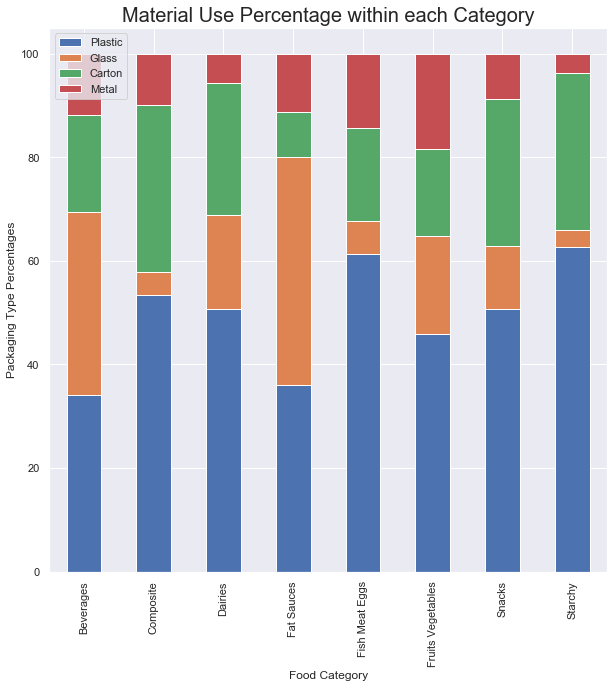

In [34]:
# We remove Fresh and Recycable categories and plot normalized bar plots for the packaging for each food category
packaging_plot_df = eco_impact_plot_df.drop('Fresh', axis =1)
packaging_plot_df = packaging_plot_df.drop('Recyclable', axis =1)
counts_pack = packaging_plot_df.groupby('food_category').sum()

plt.figure(figsize =(10,10))
ax=plt.gca()
counts_pack.div(counts_pack.sum(axis=1)/100, axis = 0).plot.bar(ax=ax, stacked=True)
plt.title('Material Use Percentage within each Category',fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Packaging Type Percentages");

While the sample size is limited, a few useful informations are depicted on the above plot. First we can see that a lot of plastic is used among every category. Moreover, glass is mainly used as a liquid container which is consistent with what we could expect. The packaging information along with the use of cooling containers and recyclability of products will be used in the analysis of different diets.

### DIET labels_en

In [ ]:
regimes = ['isVegetarian', 'isVegetalian', 'isGlutenfree', 'isLactosefree', 'isKetogenic', 'isOrganic']

In [50]:
data["labels_en"].value_counts()

Organic                                                                             18303
Gluten-free                                                                         13385
Organic,EU Organic,fr:ab-agriculture-biologique                                      6761
Green Dot                                                                            6575
Vegetarian,Vegan                                                                     5073
                                                                                    ...  
No colorings,Green Dot,No flavors                                                       1
Organic,EU Organic,100% vegetable,BE-BIO-01,EU/non-EU Agriculture,No added sugar        1
fr:fairtrade-cocoa-programme                                                            1
de:cervelas                                                                             1
FSC,FSC-C095196,FSC Mix,Green Dot                                                       1
Name: labe

In [ ]:
data["split_labels_en"]

In [82]:
def clean_caract(df,col):
    
    caracters2delete = ['%',':',',',"  ",'(',')',';','/','_','*','\d+','.','\'','[',']']

    df.loc[:,col] = df.loc[:,col].str.lower()
    for c in caracters2delete:
        df.loc[:,col] = df.loc[:,col].str.replace(c,' ')


In [83]:
data["split_labels_en"] = data["labels_en"]
clean_caract(data,"split_labels_en")
data.loc[:,"split_labels_en"] = data.loc[:,"split_labels_en"].str.split()


In [85]:
is_vegetarian_list = ['vegetarian']
not_vegetarian_list = ['meat']
data["isVGT"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_vegetarian_list for cat_word in l]) &  \
                       any([cat_word in is_vegetarian_list for cat_word in l])))


In [86]:
is_vegetalian_list = ['vegan']
not_vegetalian_list = ['meat']
data["isVGL"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_vegetalian_list for cat_word in l]) &  \
                       any([cat_word in is_vegetalian_list for cat_word in l])))

In [93]:
is_glutenfree_list = ['gluten-free']
not_glutenfree_list = ['mais']
data["isGF"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_glutenfree_list for cat_word in l]) &  \
                       any([cat_word in is_glutenfree_list for cat_word in l])))

In [92]:
is_lactosefree_list = ['lactose-free']
not_lactosefree_list = ['lait']
data["isLF"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_lactosefree_list for cat_word in l]) &  \
                       any([cat_word in is_lactosefree_list for cat_word in l])))

In [94]:
data["isLF"].value_counts()

False    199279
Name: isLF, dtype: int64

In [89]:
data["isVGL"].value_counts()

False    184082
True      15197
Name: isVGL, dtype: int64

In [90]:
len(data[(data["isVGL"]==True) & (data["isVGT"]==True)])

15197

## Diet from ingredients

In [80]:
carnivore_list = [
    'animal','animals',
    #viande
    'viande','viandes','meat','fleisch','carne',
    'bœuf','boeuf','boeufs','beef','steak','vache','cow', 'bovin','bovine',
    'charcut', 'charcuteries', 'charcuterie',
    'poulet','poulets','poule','poules','chicken','volaille','volailles',
    'porc','pork','jambons', 'jambon', 'jam','cerdo','lardon','lardons','bacon','schweinefleisch',
    'cannard','canard',
    'dinde','dindes', 'turkey',
    'boudin','foie','rillette','rillettes','couenne',
    'poitrine','cuisse','cuisses'
    'chipolata','chipolatas',
    'brebis', 'mouton'
    #poisson
    'poisson','fish', 'fisch',
    'sardine','sardines','sardina',
    'thon','thuna','tuna',
    'saumon','salmon', 'salmo'
    'hareng', 'seafood',
    'maquereaux','cabillaud','morue',
    'crevettes', 'shrimp',
    'albacore','colin','truite','moules'
]


In [81]:
# Words which reference water
#carnivore_list = ["viande"]

# Some 'categories' values contain words refering to water but are liquors
# We thus create a list to discard such products
soja_list = ["soja"]

# We clean the 'categories' column and split into words
data["split_ingredients_text"] = data["ingredients_text"]
clean_text(data,"ingredients_text")
data.loc[:,"split_ingredients_text"] = data.loc[:,"split_ingredients_text"].str.split()
#
#data["iscarnivore"] = data.loc[~data["split_ingredients_text"].isnull(),"split_ingredients_text"] \
#.apply(lambda l : bool(~any([cat_word in soja_list for cat_word in l]) &  \
#                       any([cat_word in carnivore_list for cat_word in l])))

In [82]:
data["iscarnivore"] = data.loc[~data["split_ingredients_text"].isnull(),"split_ingredients_text"] \
.apply(lambda l : bool(any([cat_word in carnivore_list for cat_word in l])))

In [83]:
data["iscarnivore"].value_counts()

False    381652
True      67570
Name: iscarnivore, dtype: int64

In [84]:
data[data["food_category"]=="Fish Meat Eggs"]

,energy_100g,sugars_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-uk_100g,nutrition_grade_fr,main_category_en,...,pnns_groups_1,pnns_groups_2,product_name,ingredients_text,nutrition_grade_fr,food_category,split_categories,iswater,split_ingredients_text,iscarnivore
15,916.0,1.7,0.5,0.1856,NaN,2.8,9.7,NaN,NaN,NaN,...,NaN,NaN,Solène céréales poulet,antioxydant érythorbate de sodium colorant car...,NaN,Fish Meat Eggs,NaN,NaN,"[antioxydant, érythorbate, de, sodium, coloran...",False
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meats,...,Fish Meat Eggs,Meat,Aiguillettes de poulet,NaN,NaN,Fish Meat Eggs,"[viandes, volailles, poulets, aiguillettes, de...",False,NaN,NaN
52,824.0,0.9,4.0,0.4400,NaN,NaN,17.0,4.0,c,Meats,...,Fish Meat Eggs,Meat,cuisse de poulet direct au four curry,NaN,c,Fish Meat Eggs,"[viandes, volailles, poulets, cuisses, de, pou...",False,NaN,NaN
58,1059.0,0.5,2.6,1.0000,NaN,NaN,23.0,15.0,d,Seafood,...,Fish Meat Eggs,Fish and seafood,Pavé de saumon fumé à la ficelle,NaN,d,Fish Meat Eggs,"[produits, de, la, mer, poissons, saumons, poi...",False,NaN,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Seafood,...,Fish Meat Eggs,Fish and seafood,pavé de saumon fumé,NaN,NaN,Fish Meat Eggs,"[produits, de, la, mer, poissons, saumons, pav...",False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038717,1686.0,0.5,16.1,0.9400,NaN,NaN,13.3,25.0,e,Meats,...,Fish Meat Eggs,Processed meat,Pâte de campagne,NaN,e,Fish Meat Eggs,"[pâté, de, campagne]",False,NaN,NaN
1038794,506.0,0.1,1.8,0.2560,NaN,NaN,8.2,NaN,NaN,NaN,...,NaN,NaN,Saumon à l'oseille,riz basmati accompagné d une sauce à l oseil...,NaN,Fish Meat Eggs,NaN,NaN,"[riz, basmati, accompagné, d, une, sauce, à, l...",True
1038854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tests,...,NaN,NaN,Test Pau 12,sel,NaN,Fish Meat Eggs,"[fr, tests, tests]",False,[sel],False
1038876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meats,...,Fish Meat Eggs,Offals,Boudin à l’ancienne,biocoop bordeaux lac distribue par les eleveur...,NaN,Fish Meat Eggs,"[en, black, pudding]",False,"[biocoop, bordeaux, lac, distribue, par, les, ...",True


# NUTRISCORE
https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/

We calculate the nutriscore according to the method described in the link above.

### Water Tag
In order to compute the NutriScore (NS) of products, we need to seperate water from other beverages.

In [35]:
# Words which reference water
water_list = ["water","waters","eau","agua"]

# Some 'categories' values contain words refering to water but are liquors
# We thus create a list to discard such products
nonwater_list = ["alkoholische","alcoholic","spirits","liquors"]

# We clean the 'categories' column and split into words
data["split_categories"] = data["categories"]
clean_text(data,"split_categories")
data.loc[:,"split_categories"] = data.loc[:,"split_categories"].str.split()

data["iswater"] = data.loc[~data["split_categories"].isnull(),"split_categories"] \
.apply(lambda l : bool(~any([cat_word in nonwater_list for cat_word in l]) &  \
                       any([cat_word in water_list for cat_word in l])))




In [36]:
data["iswater"].value_counts()

False    382600
True       1090
Name: iswater, dtype: int64

### Data Setup

In [37]:
# replace NaN of 'fruits-vegetables-nuts_100g' by 100 if it is 'Fruit juices'
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

In [38]:
selected_fields =[
    'food_category',
    'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g',
    'fiber_100g','proteins_100g',
    'nutrition-score-uk_100g','nutrition_grade_fr',
    'iswater'
]

In [39]:
# divide dataframe into 3 groups to simplify the calculation of nutriscrore
data_beverages = data[data['food_category']=='Beverages'][selected_fields]
data_fatsauces = data[data['food_category']=='Fat Sauces'][selected_fields]
data_without_beverage_fat = data[(data['food_category']!='Fat Sauces') & (data['food_category']!='Beverages') ][selected_fields]                    

### Calculation of negative points

We attribute Negative points (N) to different nutritional factors that have to be limited: energy, sugar, saturated fat and sodium

In [40]:
## ENERGY
# energy bins
energy_bins_without_beverage_fat = [data_without_beverage_fat['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_without_beverage_fat['energy_100g'].max()]
energy_bins_fatsauces = [data_fatsauces['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_fatsauces['energy_100g'].max()]
energy_bins_beverages = [data_beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, data_beverages['energy_100g'].max()]
# energy point
data_without_beverage_fat['energy_points'] = pd.cut(data_without_beverage_fat['energy_100g'], energy_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['energy_points'] = pd.cut(data_fatsauces['energy_100g'], energy_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['energy_points'] = pd.cut(data_beverages['energy_100g'], energy_bins_beverages, labels=range(11)).astype(float)


## SUGAR
# sugar bins
sugar_bins_without_beverage_fat = [data_without_beverage_fat['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_without_beverage_fat['sugars_100g'].max()]
sugar_bins_fatsauces = [data_fatsauces['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_fatsauces['sugars_100g'].max()]
sugar_bins_beverages = [data_beverages['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data_beverages['sugars_100g'].max()]
# sugar point (CHANGE SUGAR_BINS)
data_without_beverage_fat['sugar_points'] = pd.cut(data_without_beverage_fat['sugars_100g'], sugar_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['sugar_points'] = pd.cut(data_fatsauces['sugars_100g'], sugar_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['sugar_points'] = pd.cut(data_beverages['sugars_100g'], sugar_bins_beverages, labels=range(11)).astype(float)


## SATURATED FAT
# s-fat bins
fat_bins_without_beverage_fat = [data_without_beverage_fat['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_without_beverage_fat['saturated-fat_100g'].max()]
fat_bins_beverages = [data_beverages['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_beverages['saturated-fat_100g'].max()]
fat_bins_fatsauces = [data_fatsauces['saturated-fat_100g'].min() - 1, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, data_fatsauces['saturated-fat_100g'].max()]
# s-FAT point (CHANGE FAT_BINS)
data_without_beverage_fat['saturated-fat_points'] = pd.cut(data_without_beverage_fat['saturated-fat_100g'], fat_bins_without_beverage_fat, labels=range(11)).astype(float)
data_beverages['saturated-fat_points'] = pd.cut(data_beverages['saturated-fat_100g'], fat_bins_beverages, labels=range(11)).astype(float)
data_fatsauces['saturated-fat_points'] = pd.cut(data_fatsauces['saturated-fat_100g'], fat_bins_fatsauces, labels=range(11)).astype(float)


## SODIUM
# sodium bins
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
# sodium points
data_without_beverage_fat['sodium_points'] = pd.cut(data_without_beverage_fat['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_beverages['sodium_points'] = pd.cut(data_beverages['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_fatsauces['sodium_points'] = pd.cut(data_fatsauces['sodium_100g'], sodium_bins, labels=range(11)).astype(float)



### Calculation positive points

We attribute Positive points (P) to different nutritional factors that have to be promoted: fruit vegetable nuts pourcentage, fibers and proteins.

In [41]:
# FRUITS
# fruits bins
fruits_bins_without_beverage_fat = [data_without_beverage_fat['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_without_beverage_fat['fruits-vegetables-nuts_100g'].max()]
fruits_bins_fatsauces = [data_fatsauces['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_fatsauces['fruits-vegetables-nuts_100g'].max()]
fruits_bins_beverages = [data_beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_beverages['fruits-vegetables-nuts_100g'].max()]
# fruits points
data_without_beverage_fat['fruits_points'] = pd.cut(data_without_beverage_fat['fruits-vegetables-nuts_100g'], fruits_bins_without_beverage_fat, labels=[0,1,2,5]).astype(float)
data_beverages['fruits_points'] = pd.cut(data_beverages['fruits-vegetables-nuts_100g'], fruits_bins_beverages, labels=[0,2,4,10]).astype(float)
data_fatsauces['fruits_points'] = pd.cut(data_fatsauces['fruits-vegetables-nuts_100g'], fruits_bins_fatsauces, labels=[0,1,2,5]).astype(float)


# FIBRES
# fibers bins
fibers_bins = [data['fiber_100g'].min() - 1, 0.7, 1.4, 2.1, 2.8, 3.5, data['fiber_100g'].max()]
# fibers points
data_without_beverage_fat['fiber_points'] = pd.cut(data_without_beverage_fat['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_beverages['fiber_points'] = pd.cut(data_beverages['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_fatsauces['fiber_points'] = pd.cut(data_fatsauces['fiber_100g'], fibers_bins, labels=range(6)).astype(float)

# PROTEINS
# proteins bins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
# proteins points
data_without_beverage_fat['proteins_points'] = pd.cut(data_without_beverage_fat['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_beverages['proteins_points'] = pd.cut(data_beverages['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_fatsauces['proteins_points'] = pd.cut(data_fatsauces['proteins_100g'], proteins_bins, labels=range(6)).astype(float)


In [42]:
# rejoin last separated dataframe
frames = [data_without_beverage_fat, data_beverages, data_fatsauces]
nutridata = pd.concat(frames)

### Nutriscore calculation

In [43]:
# concession made to put 0 inplace of Nan of 'fruits_points','fiber_points','proteins_points' 
# this will not be a problem we do not substract Positive point
nutridata['fruits_points'] = nutridata['fruits_points'].fillna(0)
nutridata['fiber_points'] = nutridata['fiber_points'].fillna(0)
nutridata['proteins_points'] = nutridata['proteins_points'].fillna(0)

In [44]:
# calculation of P x N
nutridata['points_N']= nutridata['energy_points'] + nutridata['saturated-fat_points'] + nutridata['sugar_points'] + nutridata['sodium_points']
nutridata['points_P'] = nutridata['fruits_points'] + nutridata['fiber_points'] + nutridata['proteins_points']

In [45]:
def compute_score(row):
    N = row['points_N']
    P = row['points_P']
    fruit = row['fruits_points']
    fiber = row['fiber_points']
        
    if N < 11 or fruit == 5:
        return N - P
    else:
        return N - (fiber + fruit)
    
nutridata['nutri-score_calculated'] = nutridata.apply(compute_score, axis=1)

### Convertion of NutriScore into NutriLetter


In [46]:
# re divided dataframe to allow a simpler transformation of score into letter
nutridata_beverages = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']!=True)]
nutridata_not_beverages = nutridata[ nutridata['food_category']!='Beverages']
nutridata_beverages_water = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']==True)]

In [47]:
# NUTRILETTER

#letter bins
letter_bins_aliments = [nutridata['nutri-score_calculated'].min() - 1, 0, 2.9, 10.9, 18.9, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages = [nutridata['nutri-score_calculated'].min() - 1, 2.5, 5.5, 9.5, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages_water = [nutridata['nutri-score_calculated'].min() - 1, nutridata['nutri-score_calculated'].max()]

#letter
nutridata_not_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_not_beverages['nutri-score_calculated'], letter_bins_aliments, labels=['a','b','c','d','e'])
nutridata_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages['nutri-score_calculated'], letter_bins_beverages, labels=['b','c','d','e'])
nutridata_beverages_water['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages_water['nutri-score_calculated'], letter_bins_beverages_water, labels=['a'])


/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [48]:
nutriframes = [nutridata_not_beverages, nutridata_beverages, nutridata_beverages_water]
nutridata = pd.concat(nutriframes)

nutridata['nutri-score_letter_CALCULATED'].value_counts().sum()

770332

At the end of this process of NS calculation we obtain a NS for 770k product that represent almost 80% our the entire dataset

### Visualisation of proportion of NutriLetter label for each Food Category

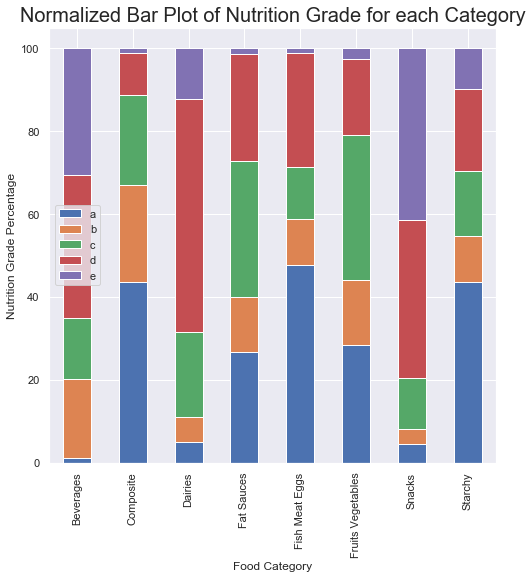

In [49]:
lettercounts =nutridata.groupby(['food_category','nutri-score_letter_CALCULATED']).count()['nutri-score_calculated']

plt.figure(figsize=(8,8))
ax=plt.gca()

lettercounts.unstack().div(lettercounts.unstack().sum(axis=1)/100,axis=0).plot.bar(ax=ax,stacked=True)
plt.legend(loc='center left')
plt.title("Normalized Bar Plot of Nutrition Grade for each Category",fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Nutrition Grade Percentage");

# Diet Study 



### Helper functions for Diet Study

In [7]:
def clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=False, langdetec=False, tokenize=False, stemming=False, lemmatizing=False, onlyEngStemmer=False, applyNounFilter=False):
    """function that appeals all cleaning methods depending of the booleans"""
    cleaned_data = pd.DataFrame()    
    cleaned_data[column_to_clean] = data[column_to_clean].copy()
    
    
    if langdetec:
        cleaned_data["languages"] = data[data[column_to_clean].notnull()][column_to_clean].apply(language_detection)
        #I found all the languages disponibles for stemming, and i map the corresponding name to the ISO_code found by langdetect.detect
        cleaned_data["languages"] = cleaned_data["languages"].map({"ar": "arabic", "da": "danish", "nl" : "dutch", "en": "english", "fi": "finnish", "fr": "french", "de": "german", \
                                  "hu": "hungarian", "it": "italian", "no": "norwegian", "ro": "romanian", "ru" : "russian", "es": "spanish", \
                                  "sv" :"swedish"})
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
       
    #tokenize column_to_clean : --> stemming + lemmatization need list of tokens
    if tokenize:
        cleaned_data[column_to_clean] = tokenize_data(cleaned_data[column_to_clean], stop_words, tokenizer, applyNounFilter)
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_token.pkl")
    else: 
        cleaned_data = pd.read_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_token.pkl") 
    
    #stemm column_to_clean column according to the language used
    if stemming:
        #for stemming, langdetection as to be made previously
        if (not(langdetec or onlyEngStemmer)):
            lang_data = pd.read_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
            cleaned_data["languages"] = lang_data["languages"].copy()
        
        cleaned_data = stemming_data(cleaned_data, column_to_clean, onlyEngStemmer)
        
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_stem.pkl")  
            
    elif lemmatizing: 
        #lemmatizing only works well for english words
        cleaned_data = lemmatizing_data(cleaned_data, column_to_clean, wordnet_lemmatizer)
        if saving: 
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_lem")    

    return cleaned_data

def filter_nountag(tokenlist_cell):
    """keep only NN : nouns, singular or mass and NNS : noun,plural and NNP : proper noun"""
    
    postag_cell = pos_tag(tokenlist_cell)
    postag_cell_filtered = [tag for tag in postag_cell if ((tag[1]=='NNS') or (tag[1] == 'NN') or (tag[1] == "NNP"))]
    tokenlist_cell = [tag[0] for tag in postag_cell_filtered]
    
    return tokenlist_cell

def tokenize_data(data_column, stop_words, tokenizer, applyNounFilter = False, tok_gaps = False):
    """Clean data, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
        - keep only tokens with tag = NN (noun), or NNS (noun, plural)
    """  
    if tok_gaps:
        data_column = data_column[data_column.notnull()].str.lower() \
            .apply(str) \
            .apply(lambda x :  "".join([ch for ch in x if ch not in string.punctuation.replace("-", "")])) \
            .apply(tokenizer.tokenize) \
            .apply(lambda cell : [item for item in cell if item not in stop_words])
        if applyNounFilter:
            data_colun = data_column[data_column.notnull()].apply(filter_nountag)
    
    else: 
        data_column = data_column[data_column.notnull()].str.lower() \
            .apply(str) \
            .apply(tokenizer.tokenize) \
            .apply(lambda cell : [item for item in cell if item not in stop_words]) 
        if applyNounFilter:
            data_column = data_column[data_column.notnull()].apply(filter_nountag)
    
    return data_column

def language_detection(category_cell): 
    """take a cell containing a the string from unprocessed dataframe and detect the language"""
    tmp_cell = str()
    tmp_cell = category_cell
    
    #supress numbers in string
    tmp_cell = tmp_cell.replace('\d+', '')
    #supress punctuations
    tmp_cell = re.sub(r'[^\w\s]','', tmp_cell)
    #remove spaces in string
    tmp_cell = ''.join(tmp_cell.split())
    
    #check if the string contain only letters --> f**king 🍩 
    if tmp_cell.isalpha():
        language = detect(category_cell)
        return detect(category_cell)
    else: 
        return None

def stemming_data(df_lang, serie_tokenlist, onlyEngStemmer = False):
    """Take as argument : 
        - df_lang = dataframe containing a serie of tokenlist, and a serie "languages" of corresponding language
        - serie_tokenlist = string name of the serie of tokenlist to stem
    """
    for i in [1, 2]:
        for index, row in df_lang[df_lang[serie_tokenlist].notnull()].iterrows():
            
            if onlyEngStemmer: 
                stemmer = SnowballStemmer("english")
            else: 
                stemmer = SnowballStemmer(row["languages"])
                df_lang.iloc[index][serie_tokenlist] = [stemmer.stem(token) for token in row[serie_tokenlist]]
 
        
    return df_lang

def lemmatizing_data(df, serie_tokenlist, wordnet_lemmatizer):
    """lemmatize serie containing token_list
        - serie_tokenlist = string name of the serie of tokenlist to lemmatize
        - df = dataframe containing "serie_tokenlist" column
        """
    for index, row in df[df[serie_tokenlist].notnull()].iterrows():
        df.iloc[index][serie_tokenlist] =  [wordnet_lemmatizer.lemmatize(token, pos="n") for token in row[serie_tokenlist]]
        #if u lemmatize verbs --> pos = "-v"
    return df


## Cleaning "categories" field

We first clean the 'categories' field and save the result in pickle format.

### -> If column field has to be cleaned

The cell below aims to clean the "categories" field and save outputs of each steps of the cleaning in pickle format. 
* create a repository in processed_pickle which has the name of the column to clean, i.e. processed_pickle/categories/ is the repository in which pickles will be saved

In [8]:
saving = False
# note : Language detection is only needed for stemming, 
# and it is a very long run (~1h)

#StopWords and Tokenizer Object initialization
stop_words = set(stopwords.words("french")).union(set(stopwords.words("english"))) #will remove only english and french stopwords
tokenizer = RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
column_to_clean = "categories"
#language detection
langdetect_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, langdetec = True)
#tokenization
tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, tokenize = True, applyNounFilter = True)
#stemming --> good since it consider language
stem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, stemming = True)
#lemmatize --> not very good since it does not consider language (only good for english)
lem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, lemmatizing = True)

### -> If column field already cleaned and saved in pkl

In [9]:
column = "categories"
langdetect_data = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_langdetect.pkl")
categories_tok = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_token.pkl") 
categories_stem = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_stem.pkl") 
categories_lem = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_lem.pkl") 

In [10]:
categories_dict = categories_stem[categories_stem["categories"].notnull()]["categories"].explode().value_counts()
for word in categories_dict[categories_dict>500].index:
    print(word)

aliment
boisson
produit
snack
fruit
lait
fromag
plat
céréal
biscuit
bas
plant
food
sauc
viand
pomm
légum
dessert
végétal
pât
confitur
beverag
poisson
chocolat
product
yaourt
déjeun
lebensmittel
nectar
jus
conserv
pet
cereal
charcut
getrank
mat
pflanzlich
snacks
chip
fr
pain
orig
grain
huil
tartin
epic
grass
glac
franc
poulet
vin
confis
coqu
miel
ajout
milk
crem
soup
surgel
légumin
bonbon
volaill
san
bi
prépar
compot
filet
marmelad
tart
foi
jambons
salad
rillet
frut
sirop
oliv
sardin
thon
alimentair
cuit
jambon
roug
chocolats
sorbet
juic
élevag
steak
beb
cond
veget
terrin
pickl
spread
flocon
édulcor
tomat
barr
beurr
sauces
saumon
frais
meal
cream
vert
sus
meat
vegetal
beverages
chocol
pâtiss
viennois
riz
milch
yogurt
orang
sech
champignon
sandwich
chaud
brioch
dulc
caf
fraîch
charcuteri
dairi
galet
noiset
milchprodukt
quich
bread
noir
tea
mélang
gazeux
onde
crêp
gâteau
chee
lech
natur
viandes
vinaigres
multifruit
pur
moutard
emmental
enti
biscuits
fleur
aliments
verdur
amand
infus
groce

## Diet Dictionary for categories field

We create dictionary for each diets. They have a YES list and NO list. A product is considered part of the diet is it has at least ONE element in its YES list (if not empty) and NO element in its NO list (if not empty).

In [10]:
regimes = ['isVegetarian', 'isVegetalian', 'isGlutenfree', 'isLactosefree', 'isKetogenic', 'isOrganic']

In [11]:
#Initialization needed to create a serie containing unauthorized items  for each of the diets
unauthorized_categories = pd.Series(index = regimes).rename('unauthorized_categories')

unauthorized_listnames_categories = ['categories_' + str(x) + '_NOlist' for x in regimes]
unauthorized_listnames_categories

#Initialization needed to create a serie containing authorized items for each of the diets
authorized_categories = pd.Series(index = regimes).rename('authorized_labelsen')

authorized_listnames_categories = ['categories_' + str(x) + '_YESlist' for x in regimes]
authorized_listnames_categories

['categories_isVegetarian_YESlist',
 'categories_isVegetalian_YESlist',
 'categories_isGlutenfree_YESlist',
 'categories_isLactosefree_YESlist',
 'categories_isKetogenic_YESlist',
 'categories_isOrganic_YESlist']

In [30]:
# GENERAL LISTS
viand_list =  ['foi', 'sauc', 'steak', 'viand', 'viandes', 'meat', 'beef', 'poisson', 'charcut', 'charcuteries', 'charcuteri', 'poulet', 'poul', 'volaill', 'jambons', 'jambon', 'jam', 'rillet', 'sardin', 'thon', 'steak', 'saumon', 'salmon', 'escalop', 'dind', 'jam', \
               'terrin', 'boudin', 'animal', 'cannard', 'porc', 'lasagn', 'cuiss', 'fish', 'crevet', 'fleisch', 'vach', 'chipolat', 'fisch', 'lardon', 'bacon', 'hareng', 'seafood', 'chicken', 'breb', 'bovin']

lactose_list = ['fromag', 'lait', 'yaourt', 'bi', 'écrem', 'cream', 'crem', 'glac', 'milk', 'milks', 'dairi', 'dair', 'dairies', 'beurr', 'milch', 'milchprodukt', 'chee', \
                                'cake', 'crêp', 'bread', 'gâteau' , 'lait', 'butter', 'butt', 'cooki', 'emmental', 'comt', 'camembert', 'margarin', 'kas', 'cheddar', 'yogurt', 'yogur', 'yogurts']

gluten_list = ['pât', 'pasta', 'pâtiss', 'past', 'nouill', 'viennois', 'biscuit', 'biscuits', 'sauc', 'sauces', 'charcut', 'charcuteri', 'charcuteries', 'bread', 'crêp', 'gâteau', 'farin', 'farines', 'pizz', 'pizzas', 'cake', 'madelein', \
               'brotaufstrich', 'brot', 'beignet', 'lasagn', 'raviol', 'blé', 'wheat', 'bi', 'pies', 'kuch', 'muffin', 'gaufr', 'gaufret', 'biscott', 'cooki', 'cook', 'brot']

fruit_list =  ['fruits','fruit', 'multifruit', 'pomm', 'confitur','nectar', 'nect', 'jus', 'juic','frut', 'sorbet', 'tomat', 'tomato', 'orang', 'compotes', 'marmelad'] 

legum_list = ['legum', 'légum',  'plant', 'végétal', 'vegetal', 'pflanzlich', 'salad',  'verdur', 'haricot',  'amand', 'veget',  'carott', 'oignon']

fat_list = ['huil', 'oil', 'oils', 'fat', 'gras', 'grass'] 

egg_list = ['mayon', 'mayonnaises', 'mayonnaises', 'moutardes', 'mustard', 'egg', 'œuf']

# Vegetarian_NOlist = regimes(0)
categories_Vegetarian_NOlist = viand_list
categories_Vegetarian_YESlist = lactose_list + \
                                fruit_list + \
                                legum_list + \
                                fat_list + \
                                egg_list 

# Lactosefree = regime(3)
categories_Lactosefree_NOlist = lactose_list
categories_Lactosefree_YESlist = viand_list + \
                                 fruit_list + \
                                 legum_list + \
                                 fat_list + \
                                 ['céréal', 'céréales', 'cereal', 'getreid', 'pât', 'sauces', 'sauc', \
                                  'chips', 'chip', 'confiseries', 'confiseri', 'pain', 'huil', 'vin', 'vinaigres', \
                                  'vinaigr', 'vinaigret', 'miel',  'bonbon', \
                                  'grain', 'sirop', 'pickl', 'flocon',  'oliv', \
                                  'riz', 'moutardes', 'moutard', 'champignon', 'farin', 'farines', 'noiset', 'caf', 'bean', 'pasta',\
                                  'escalop', 'flake', 'flak', 'bouillon', 'seed', 'wine', 'win', 'potato', 'sod', 'nut', 'nouill', 'lentill', 'candi', \
                                  'corn', 'sel', 'sucr', 'thé', 'tournesol', 'semoul', 'vert', 'muesl', 'pur', 'épic', 'vanill', 'minéral', 'minerales']


#Vegan_NOlist = regimes(1)
categories_Vegetalian_NOlist = lactose_list + \
                          viand_list + \
                          egg_list

categories_Vegetalian_YESlist = legum_list + \
                           fruit_list 

#Glutenfree = regime(2)
categories_Glutenfree_NOlist = gluten_list
categories_Glutenfree_YESlist = fruit_list + \
                                legum_list + \
                                egg_list + \
                                fat_list


#Ketogenic = regimes(4)
categories_Ketogenic_NOlist = fruit_list + \
                              ['sucr', 'confiseries', 'confiseri', 'confis' , 'nouill', 'semoul', 'legumin', 'légumin', 'potato', 'bean', 'haricot', 'lentill', 'lentill', 'riz', 'pasta', \
                               'pasta', 'milk', 'milks', 'sirop', 'candi', 'jus', 'juic', 'tart', 'marmelad', 'snack', 'snacks', 'biscuit', 'pât', 'confitur', 'chocolat', 'chocolats', 'chocol', \
                               'nectar', 'nect', 'bread', 'chip', 'chips', 'pain', 'miel', 'bonbon', 'compot', 'pâtiss']

categories_Ketogenic_YESlist = lactose_list + \
                               viand_list + \
                               fat_list + \
                               egg_list  + \
                               legum_list + \
                               ['grain', 'nut', 'tomato', 'tomat', 'seed']



#Organic = regimes(5)
categories_Organic_NOlist = []
categories_Organic_YESlist = []


categories_YESlists = [categories_Vegetarian_YESlist, categories_Vegetalian_YESlist, \
                      categories_Glutenfree_YESlist, categories_Lactosefree_YESlist, \
                      categories_Ketogenic_YESlist, categories_Organic_YESlist]

categories_NOlists = [categories_Vegetarian_NOlist, categories_Vegetalian_NOlist, \
                      categories_Glutenfree_NOlist, categories_Lactosefree_NOlist, \
                      categories_Ketogenic_NOlist, categories_Organic_NOlist]

## Cleaning labels_en field

The 'label_en' column is used to complete the diet attribution of products

In [13]:
saving = True
# note : Language detection is only needed for stemming, 
# and it is a very long run (~1h)

#StopWords and Tokenizer Object initialization
stop_words = set(stopwords.words("french")).union(set(stopwords.words("english"))) #will remove only english and french stopwords
wordnet_lemmatizer = WordNetLemmatizer()


tokenizer = RegexpTokenizer(r'\w+')

#here we use tokenizer gaps to keep compounds words (don't separate words with dashe, e.g. gluten-free --> "gluten-free")
tokenizer_gaps = RegexpTokenizer('\s+', gaps=True)


In [14]:
column_to_clean = "labels_en"

#tokenization
tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=True, tokenize=True)
#stemming --> good since it consider language
stem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=True, stemming=True, onlyEngStemmer=True)

In [15]:
label_tok = pd.read_pickle("exploration/processed_pickle/labels_en/out_token.pkl")
label_stem = pd.read_pickle("exploration/processed_pickle/labels_en/out_stem.pkl")

#With gap, gluten-free is not separated in 'gluten' 'free'
label_tokgap = pd.read_pickle("exploration/processed_pickle/labels_en/out_tokengap.pkl")
label_stemgap = pd.read_pickle("exploration/processed_pickle/labels_en/out_stemgap.pkl")

## Diet Dictionary for labels_en field

The same methodology is used for obtaining diet information from the 'labels_en' column and completing our diet categorization

In [16]:
data[data["labels_en"].notnull()]["labels_en"].value_counts().head(50)

Organic                                                                            18264
Gluten-free                                                                        12392
Organic,EU Organic,fr:ab-agriculture-biologique                                     6804
Green Dot                                                                           6570
Vegetarian,Vegan                                                                    4911
Made in France                                                                      4903
No preservatives                                                                    3694
No colorings                                                                        2764
No added sugar                                                                      2224
Organic,EU Organic,FR-BIO-01                                                        2051
No colorings,No preservatives                                                       1775
Organic,EU Organic,FR

In [17]:
labelsen_dict = label_stem[label_stem["labels_en"].notnull()]["labels_en"].explode().value_counts()
for word in labelsen_dict[labelsen_dict > 1000].index:
    print(word)

organic
fr
agriculture
free
gluten
green
dot
made
france
bio
ab
biologique
vegetarian
vegan
preservatives
01
colorings
sugar
non
nutriscore
viande
french
added
low
oil
palm
francaise
sustainable
lactose
carbon
footprint
eco
fsc
öko
flavors
artificial
certified
grade
emballages
fat
halal
milk
française
pork
salt
utz
high
quality
germany
pure
natural
pdo
meat
pgi
labels
society
gmos
italy
distributor
fair
trade
lait
transformed
german
agricultural
femmes
enceintes
déconseillé
006
kosher
additives
001
100
triman
msc
francais
10
fishery
union
seafood
superior
butter
bretagne
produced
bovine
reduced
farming
sélection
intermarché
porcine
nl
sans
medal
ru
label
français
without
volaille
european
origine
mix
source
concours
fibres
cacao
belgium
gold
oko
max
havelaar
colors
saveurs
spain
eg
verordnung
agricole
ecocert
007
général
3
class
b


In [18]:
#Initialization needed to create a serie containing authorized items for each of the diets
authorized_labelsen = pd.Series(index = regimes).rename('authorized_labelsen')

authorized_listnames_labelsen = ['labelsen_' + str(x) + '_YESlist' for x in regimes]
authorized_listnames_labelsen

#Initialization needed to create a serie containing unauthorized items  for each of the diets
unauthorized_labelsen = pd.Series(index = regimes).rename('unauthorized_labelsen')

unauthorized_listnames_labelsen = ['labelsen_' + str(x) + '_NOlist' for x in regimes]
unauthorized_listnames_labelsen

['labelsen_isVegetarian_NOlist',
 'labelsen_isVegetalian_NOlist',
 'labelsen_isGlutenfree_NOlist',
 'labelsen_isLactosefree_NOlist',
 'labelsen_isKetogenic_NOlist',
 'labelsen_isOrganic_NOlist']

In [22]:
#Organic = regimes(5)
labelsen_Organic_YESlist = ['organic', 'bio', 'biologique']
#Ketogenic = regimes(4)
labelsen_Ketogenic_YESlist = []

#Lactosefree = regime(3) #since lactose only appears as NO lactose
labelsen_Lactosefree_YESlist = ['lactose']

#Glutenfree = regime(2)
labelsen_Glutenfree_YESlistgap = ['gluten-free']
labelsen_Glutenfree_YESlist  = ['gluten']
#Vegan_NOlist = regimes(1)
labelsen_Vegetalian_YESlist = ['vegan']

#Vegetarian_NOlist = regimes(0)
labelsen_Vegetarian_YESlist = ['vegetarian']

labelsen_YESlistsgap = [labelsen_Vegetarian_YESlist, labelsen_Vegetalian_YESlist, labelsen_Glutenfree_YESlistgap, \
                    labelsen_Lactosefree_YESlist, labelsen_Ketogenic_YESlist, labelsen_Organic_YESlist]

labelsen_YESlists = [labelsen_Vegetarian_YESlist, labelsen_Vegetalian_YESlist, labelsen_Glutenfree_YESlist, \
                    labelsen_Lactosefree_YESlist, labelsen_Ketogenic_YESlist, labelsen_Organic_YESlist]

## Diet series creation

We create the series representing possible the diet regimes of products

### Lets first try with _labels_en_

In [23]:
labelsen_YESlists

[['vegetarian'],
 ['vegan'],
 ['gluten'],
 ['lactose'],
 [],
 ['organic', 'bio', 'biologique']]

In [87]:
def isDiet(input_df, split_col, regimes, YES_List = None, NO_List = None): 
    """ Create isDiet columns (isVegetarian, isVegetalian,...) containing bool cell for each product, True or False"""
    data = input_df.copy()
    #print("Hello, isDiet is called")
    for index, isRegime in enumerate(regimes): 
        
        if ((YES_List!=None) & (NO_List==None)):
            tmp_data = data.loc[data[split_col].notnull(), split_col].copy()
            tmp_diet = tmp_data.apply(lambda token_list : bool(any([token in YES_List[index] for token in token_list])))
            
            #If isRegime already exist, just complete the lines still NaN, or Bool that are False
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                #print("Create New " + isRegime + " field 1")
                data[isRegime] = tmp_diet
            
        elif (YES_List!=None) & (NO_List!=None): 
            tmp_data = data.loc[data[split_col].notnull(), split_col].copy()
            tmp_diet = tmp_data.apply(lambda token_list : bool((any([token in YES_List[index] for token in token_list])) & \
                                                                (all([token not in NO_List[index] for token in token_list]))))

            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
            
        elif ((YES_List==None) & (NO_List!=None)):
            tmp_data = data.loc[data[split_col].notnull(), split_col]
            tmp_diet = tmp_data.apply(lambda token_list : bool(all([token not in NO_List[index] for token in token_list]))) 
            
            if isRegime in data.columns:
                #print("Complete only False and None 3")
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                #print("Create New " + isRegime + " field 3")
                data[isRegime] = tmp_diet
                
    return data

### Let's try with _categories_ field

In [61]:
#Test if isDiet booleans check if word in/not in list work as i want. 
test_df = pd.DataFrame()
test_serie = pd.Series([[str('mayon'), str('pasta'), str('milk'), str('fruits')], \
                        [str('pasta'), str('fruits')], \
                        [str('steak'), str('milk'), str('fruits')], \
                        [str('steak'), str('pasta'), str('fruits')],\
                        [str('steak'), str('pasta'), str('milk')], \
                        [str('')], \
                        [str('mayon'), str('milk'), str('fruits')], \
                        [str('milk'), str('fruits')], \
                        [str('steak'), str('fruits')], \
                        [str('steak'), str('milk')], \
                        [str('steak'), str('pasta'), str('milk'), str('fruits')]])
test_serie1 = pd.Series([['vege'], ['vegan + vege + lactose-free'], ['gluten-free'],['lactose-free'], ['ketogenic'], [''], ['vege + gluten-free'], \
                         ['vege + gluten-free'], ['gluten-free + lactose-free'], ['gluten-free + ketogenic'], ['All False']])
test_df["categories_tok"] = test_serie
test_df["expected_output"] = test_serie1
test_df

,categories_tok,expected_output
0,"[mayon, pasta, milk, fruits]",[vege]
1,"[pasta, fruits]",[vegan + vege + lactose-free]
2,"[steak, milk, fruits]",[gluten-free]
3,"[steak, pasta, fruits]",[lactose-free]
4,"[steak, pasta, milk]",[ketogenic]
5,[],[]
6,"[mayon, milk, fruits]",[vege + gluten-free]
7,"[milk, fruits]",[vege + gluten-free]
8,"[steak, fruits]",[gluten-free + lactose-free]
9,"[steak, milk]",[gluten-free + ketogenic]


In [62]:
test_df = isDiet(test_df, "categories_tok", regimes[:5], YES_List = categories_YESlists[:5], NO_List = categories_NOlists[:5])
test_df

,categories_tok,expected_output,isVegetarian,isVegetalian,isGlutenfree,isLactosefree,isKetogenic
0,"[mayon, pasta, milk, fruits]",[vege],True,False,False,False,False
1,"[pasta, fruits]",[vegan + vege + lactose-free],True,True,False,True,False
2,"[steak, milk, fruits]",[gluten-free],False,False,True,False,False
3,"[steak, pasta, fruits]",[lactose-free],False,False,False,True,False
4,"[steak, pasta, milk]",[ketogenic],False,False,False,False,False
5,[],[],False,False,False,False,False
6,"[mayon, milk, fruits]",[vege + gluten-free],True,False,True,False,False
7,"[milk, fruits]",[vege + gluten-free],True,False,True,False,False
8,"[steak, fruits]",[gluten-free + lactose-free],False,False,True,True,False
9,"[steak, milk]",[gluten-free + ketogenic],False,False,False,False,False


>Seems to works well when creating the new fields. Let's see if it also works when the field has already been created et when it only needs to complete None and False 

In [80]:
test_df = pd.DataFrame()
test_serie2 = pd.Series([[''], \
                         [''], \
                         [''], \
                         [''], \
                         [''], \
                         ['gluten'], \
                         [''], \
                         [''], \
                         [''], \
                         [''], \
                         ['']])
test_serie = pd.Series([[str('mayon'), str('pasta'), str('milk'), str('fruits')], \
                        [str('pasta'), str('fruits')], \
                        [str('steak'), str('milk'), str('fruits')], \
                        [str('steak'), str('pasta'), str('fruits')],\
                        [str('steak'), str('pasta'), str('milk')], \
                        [str('')], \
                        [str('mayon'), str('milk'), str('fruits')], \
                        [str('milk'), str('fruits')], \
                        [str('steak'), str('fruits')], \
                        [str('steak'), str('milk')], \
                        [str('steak'), str('pasta'), str('milk'), str('fruits')]])
test_serie1 = pd.Series([['vege'], ['vegan + vege + lactose-free'], ['gluten-free'],['lactose-free'], ['ketogenic'], ['gluten-free'], ['vege + gluten-free'], \
                         ['vege + gluten-free'], ['gluten-free + lactose-free'], ['gluten-free + ketogenic'], ['All False']])
test_df["categories_tok"] = test_serie
test_df["labelsen_tok"] = test_serie2
test_df["expected_output"] = test_serie1
test_df

,categories_tok,labelsen_tok,expected_output
0,"[mayon, pasta, milk, fruits]",[],[vege]
1,"[pasta, fruits]",[],[vegan + vege + lactose-free]
2,"[steak, milk, fruits]",[],[gluten-free]
3,"[steak, pasta, fruits]",[],[lactose-free]
4,"[steak, pasta, milk]",[],[ketogenic]
5,[],[gluten],[gluten-free]
6,"[mayon, milk, fruits]",[],[vege + gluten-free]
7,"[milk, fruits]",[],[vege + gluten-free]
8,"[steak, fruits]",[],[gluten-free + lactose-free]
9,"[steak, milk]",[],[gluten-free + ketogenic]


In [81]:
test_df = isDiet(test_df, "categories_tok", regimes[:5], YES_List = categories_YESlists[:5], NO_List = categories_NOlists[:5])
test_df = isDiet(test_df, "labelsen_tok", regimes[:5], YES_List = labelsen_YESlists[:5])
test_df

,categories_tok,labelsen_tok,expected_output,isVegetarian,isVegetalian,isGlutenfree,isLactosefree,isKetogenic
0,"[mayon, pasta, milk, fruits]",[],[vege],True,False,False,False,False
1,"[pasta, fruits]",[],[vegan + vege + lactose-free],True,True,False,True,False
2,"[steak, milk, fruits]",[],[gluten-free],False,False,True,False,False
3,"[steak, pasta, fruits]",[],[lactose-free],False,False,False,True,False
4,"[steak, pasta, milk]",[],[ketogenic],False,False,False,False,False
5,[],[gluten],[gluten-free],False,False,True,False,False
6,"[mayon, milk, fruits]",[],[vege + gluten-free],True,False,True,False,False
7,"[milk, fruits]",[],[vege + gluten-free],True,False,True,False,False
8,"[steak, fruits]",[],[gluten-free + lactose-free],False,False,True,True,False
9,"[steak, milk]",[],[gluten-free + ketogenic],False,False,False,False,False


>Seems to work well in that case too! (see line 5). Lets try on the real data

In [88]:
#Here we use the tokenizer with gaps = True (keep gluten-free as 'gluten-free')
data["labels_en_tokgap"] = label_stemgap["labels_en"]
data_labeldietgap = isDiet(data, "labels_en_tokgap", regimes, labelsen_YESlistsgap)

#Here we use the tokenier with gaps = False (gluten-free becomes 'gluten' 'free')
data["labels_en_tok"] = label_stem["labels_en"]
data_labeldiet = isDiet(data, "labels_en_tok", regimes, labelsen_YESlists)


In [89]:
print("Using labels_en field with gap tokenizer, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(data_labeldietgap[data_labeldietgap["labels_en_tokgap"].notnull()][isRegime].value_counts()) == 2:
        percentage = data_labeldietgap[data_labeldietgap["labels_en_tokgap"].notnull()][isRegime].value_counts()[1]/len(data_labeldietgap)*100
        nb_true = data_labeldietgap[data_labeldietgap["labels_en_tokgap"].notnull()][isRegime].value_counts()[1]
        nb_false = data_labeldietgap[data_labeldietgap["labels_en_tokgap"].notnull()][isRegime].value_counts()[0]
    elif len(data_labeldietgap[data_labeldietgap["labels_en_tokgap"].notnull()][isRegime].value_counts()) == 1:
        percentage = 0; 
        nb_true = 0; 
        nb_false = data_labeldietgap[data_labeldietgap["labels_en_tokgap"].notnull()][isRegime].value_counts()[0]
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                

    
print("\n\n Using labels_en field with normal tokenizer, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(data_labeldiet[data_labeldiet["labels_en_tok"].notnull()][isRegime].value_counts()) == 2:
        percentage = data_labeldiet[data_labeldiet["labels_en_tok"].notnull()][isRegime].value_counts()[1]/len(data_labeldiet)*100
        nb_true = data_labeldiet[data_labeldiet["labels_en_tok"].notnull()][isRegime].value_counts()[1]
        nb_false = data_labeldiet[data_labeldiet["labels_en_tok"].notnull()][isRegime].value_counts()[0]
    elif len(data_labeldiet[data_labeldiet["labels_en_tok"].notnull()][isRegime].value_counts()) == 1:
        percentage = 0; 
        nb_true = 0; 
        nb_false = data_labeldiet[data_labeldiet["labels_en_tok"].notnull()][isRegime].value_counts()[0]
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 

Using labels_en field with gap tokenizer, we managed to classified : 

isVegetarian : 1667 True and 193084 False --> 0 %  product of total data set isVegetarian
isVegetalian : 285 True and 194466 False --> 0 %  product of total data set isVegetalian
isGlutenfree : 12392 True and 182359 False --> 1 %  product of total data set isGlutenfree
isLactosefree : 4461 True and 190290 False --> 0 %  product of total data set isLactosefree
isKetogenic : 0 True and 194751 False --> 0 %  product of total data set isKetogenic
isOrganic : 19433 True and 175318 False --> 2 %  product of total data set isOrganic


 Using labels_en field with normal tokenizer, we managed to classified : 

isVegetarian : 17563 True and 177188 False --> 1 %  product of total data set isVegetarian
isVegetalian : 14969 True and 179782 False --> 1 %  product of total data set isVegetalian
isGlutenfree : 26677 True and 168074 False --> 2 %  product of total data set isGlutenfree
isLactosefree : 5870 True and 188881 False --> 

>Regarding the previous output, we will use preferentially the normal tokenizer

### Merging the results. 

Keeping in mind that _labels_en_ founding is prioritary (diet are explicit in that field)

In [91]:
data_diet = data.copy()
data_diet["labels_en_tok"] = label_stem["labels_en"]
data_diet["categories_tok"] = categories_stem["categories"]
data_diet = isDiet(data_diet, 'labels_en_tok', regimes, YES_List = labelsen_YESlists)

print("Using labels fields, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    
    if len(data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()) == 2:
        percentage = data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()[1]/len(data_diet)*100
        nb_true = data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()[1]
        nb_false = data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()[0]
        
    elif len(data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()) == 1:
        percentage = 0; 
        nb_true = 0; 
        nb_false = data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()[0]
        
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                



data_diet = isDiet(data_diet, 'categories_tok', regimes, YES_List = categories_YESlists, NO_List = categories_NOlists)

print("\n Using both fields, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    
    if len(data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()) == 2:
        percentage = data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()[1]/len(data_diet)*100
        nb_true = data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()[1]
        nb_false = data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()[0]
        
    elif len(data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()) == 1:
        percentage = 0; 
        nb_true = 0; 
        nb_false = data_diet[data_diet[isRegime].notnull()][isRegime].value_counts()[0]
        
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                


Using labels fields, we managed to classified : 

isVegetarian : 17563 True and 177188 False --> 1 %  product of total data set isVegetarian
isVegetalian : 14969 True and 179782 False --> 1 %  product of total data set isVegetalian
isGlutenfree : 26677 True and 168074 False --> 2 %  product of total data set isGlutenfree
isLactosefree : 5870 True and 188881 False --> 0 %  product of total data set isLactosefree
isKetogenic : 0 True and 194751 False --> 0 %  product of total data set isKetogenic
isOrganic : 64396 True and 130355 False --> 7 %  product of total data set isOrganic

 Using both fields, we managed to classified : 

isVegetarian : 145056 True and 292651 False --> 16 %  product of total data set isVegetarian
isVegetalian : 84365 True and 353342 False --> 9 %  product of total data set isVegetalian
isGlutenfree : 102562 True and 335145 False --> 11 %  product of total data set isGlutenfree
isLactosefree : 179632 True and 258075 False --> 20 %  product of total data set isLacto